In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import pandas as pd
from torchsummary import summary


In [ ]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
return x

In [ ]:
def entry_flow(inputs):

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual
  
  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for size in [128, 256, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(  # Project residual
        size, 1, strides=2, padding='same')(previous_block_activation)           
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  return x


def middle_flow(x, num_blocks=8):
  
  previous_block_activation = x

  for _ in range(num_blocks):
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, previous_block_activation])  # Add back residual
    previous_block_activation = x  # Set aside next residual
    
  return x


def exit_flow(x, num_classes=2):
  
  previous_block_activation = x

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  
  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.SeparableConv2D(1536, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.SeparableConv2D(2048, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  
  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'
  return layers.Dense(num_classes, activation=activation)(x)


# Free up the previously created models
keras.backend.clear_session()

# Create Xception by chaining the 3 flows
inputs = keras.Input(shape=(299, 299, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = keras.Model(inputs, outputs)
xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
xception.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
#loading training and test data
train_path = "/content/drive/MyDrive/chest_xray/chest_xray/train"
valid_path = "/content/drive/MyDrive/chest_xray/chest_xray/test"
# Function for creating csv with filenames and labels
  def create_csv(self):
    fnames, classid = [], []
    for f in self.f_pos:
      fnames.append(f)
      classid.append("PNEUMONIA")
    for fn in self.f_neg:
      fnames.append(fn)
      classid.append("NORMAL")
    random.shuffle(fnames)
    random.shuffle(classid)
    self.df = pd.DataFrame({"id":fnames, "label":classid})
    print(self.df.head())
    #loading dataset
   train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, #randomly zoom image
                                   horizontal_flip = True) #randomly flip image
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
history = xception.fit_generator(
    training_set,
    steps_per_epoch=80,
    epochs=10,
    validation_data=test_set,
    validation_steps=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
80/80 [==============================] - 675s 8s/step - loss: 0.3545 - accuracy: 0.8479 - val_loss: 0.6685 - val_accuracy: 0.6250
Epoch 2/10
80/80 [==============================] - 345s 4s/step - loss: 0.1999 - accuracy: 0.9218 - val_loss: 0.6617 - val_accuracy: 0.6250
Epoch 3/10
80/80 [==============================] - 212s 3s/step - loss: 0.1833 - accuracy: 0.9281 - val_loss: 0.6637 - val_accuracy: 0.6250
Epoch 4/10
80/80 [==============================] - 150s 2s/step - loss: 0.1934 - accuracy: 0.9292 - val_loss: 0.6940 - val_accuracy: 0.6250
Epoch 5/10
80/80 [==============================] - 130s 2s/step - loss: 0.1716 - accuracy: 0.9328 - val_loss: 1.2060 - val_accuracy: 0.6250
Epoch 6/10
80/80 [==============================] - 122s 2s/step - loss: 0.1396 - accuracy: 0.9496 - val_loss: 2.0705 - val_accuracy: 0.6250
Epoch 7/10
80/80 [==============================] - 118s 1s/step - loss: 0.1693 - accuracy: 0.9355 - val_loss: 1.9995 - val_accuracy: 0.6250
Epoch 8/10
80

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


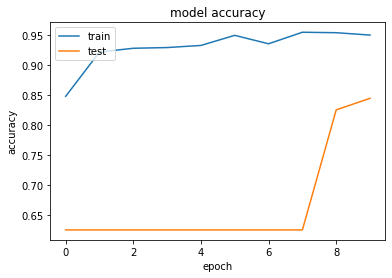

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

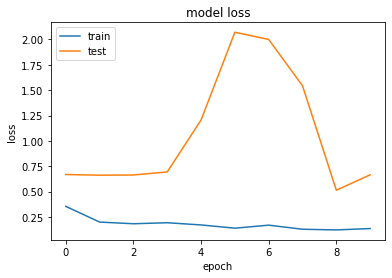

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()